In [1]:
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
import random
import matplotlib.patheffects as PathEffects
from tensorflow.keras.datasets import cifar10 as cifar10

## for Model definition/training
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, concatenate,  Dropout, Conv2D, BatchNormalization, MaxPool2D, Activation, Dense
from tensorflow.keras.optimizers import Adam, Nadam, Adadelta,SGD
from tensorflow.keras import regularizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

In [3]:
from collections import defaultdict
from matplotlib import pyplot as plt
import seaborn as sns


In [4]:
base_dir = 'data/'

In [14]:
import os


id1= len(os.listdir(base_dir+'/0'))
id2 = len(os.listdir(base_dir+'/1'))
id3 = len(os.listdir(base_dir+'/2'))
id4 = len(os.listdir(base_dir+'/3'))
id5 = len(os.listdir(base_dir+'/4'))
id6 = len(os.listdir(base_dir+'/5'))
id7=len(os.listdir(base_dir+'/6'))
id8=len(os.listdir(base_dir+'/7'))

print('total id1:', id1)
print('total id2 :',id2)
print('total id3 :', id3)
print('total id4 :', id4)
print('total id5 :', id5)
print('total id6 :', id6)
print('total id7 :', id7)
print('total id8 :', id8)

total_data = id1+id2+id3+id4+id5+id6+id7+id8
print(total_data)

total id1: 319
total id2 : 325
total id3 : 330
total id4 : 318
total id5 : 330
total id6 : 330
total id7 : 321
total id8 : 284
2557


In [15]:
def pairwise_distance(feature, squared=False):
    """Computes the pairwise distance matrix with numerical stability.

    output[i, j] = || feature[i, :] - feature[j, :] ||_2

    Args:
      feature: 2-D Tensor of size [number of data, feature dimension].
      squared: Boolean, whether or not to square the pairwise distances.

    Returns:
      pairwise_distances: 2-D Tensor of size [number of data, number of data].
    """
    pairwise_distances_squared = math_ops.add(
        math_ops.reduce_sum(math_ops.square(feature), axis=[1], keepdims=True),
        math_ops.reduce_sum(
            math_ops.square(array_ops.transpose(feature)),
            axis=[0],
            keepdims=True)) - 2.0 * math_ops.matmul(feature,
                                                    array_ops.transpose(feature))

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = math_ops.maximum(pairwise_distances_squared, 0.0)
    # Get the mask where the zero distances are at.
    error_mask = math_ops.less_equal(pairwise_distances_squared, 0.0)

    # Optionally take the sqrt.
    if squared:
        pairwise_distances = pairwise_distances_squared
    else:
        pairwise_distances = math_ops.sqrt(
            pairwise_distances_squared + math_ops.to_float(error_mask) * 1e-16)

    # Undo conditionally adding 1e-16.
    pairwise_distances = math_ops.multiply(
        pairwise_distances, math_ops.to_float(math_ops.logical_not(error_mask)))

    num_data = array_ops.shape(feature)[0]
    # Explicitly set diagonals to zero.
    mask_offdiagonals = array_ops.ones_like(pairwise_distances) - array_ops.diag(
        array_ops.ones([num_data]))
    pairwise_distances = math_ops.multiply(pairwise_distances, mask_offdiagonals)
    return pairwise_distances

def masked_maximum(data, mask, dim=1):
    """Computes the axis wise maximum over chosen elements.

    Args:
      data: 2-D float `Tensor` of size [n, m].
      mask: 2-D Boolean `Tensor` of size [n, m].
      dim: The dimension over which to compute the maximum.

    Returns:
      masked_maximums: N-D `Tensor`.
        The maximized dimension is of size 1 after the operation.
    """
    axis_minimums = math_ops.reduce_min(data, dim, keepdims=True)
    masked_maximums = math_ops.reduce_max(
        math_ops.multiply(data - axis_minimums, mask), dim,
        keepdims=True) + axis_minimums
    return masked_maximums

def masked_minimum(data, mask, dim=1):
    """Computes the axis wise minimum over chosen elements.

    Args:
      data: 2-D float `Tensor` of size [n, m].
      mask: 2-D Boolean `Tensor` of size [n, m].
      dim: The dimension over which to compute the minimum.

    Returns:
      masked_minimums: N-D `Tensor`.
        The minimized dimension is of size 1 after the operation.
    """
    axis_maximums = math_ops.reduce_max(data, dim, keepdims=True)
    masked_minimums = math_ops.reduce_min(
        math_ops.multiply(data - axis_maximums, mask), dim,
        keepdims=True) + axis_maximums
    return masked_minimums

In [16]:
import tensorflow as tf
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import array_ops
from tensorflow import dtypes
def triplet_loss_adapted_from_tf(y_true, y_pred):
    del y_true
    margin = 1.
    labels = y_pred[:, :1]

 
    labels = tf.cast(labels, dtype='int32')

    embeddings = y_pred[:, 1:]

    ### Code from Tensorflow function [tf.contrib.losses.metric_learning.triplet_semihard_loss] starts here:
    
    # Reshape [batch_size] label tensor to a [batch_size, 1] label tensor.
    # lshape=array_ops.shape(labels)
    # assert lshape.shape == 1
    # labels = array_ops.reshape(labels, [lshape[0], 1])

    # Build pairwise squared distance matrix.
    pdist_matrix = pairwise_distance(embeddings, squared=True)
    # Build pairwise binary adjacency matrix.
    adjacency = math_ops.equal(labels, array_ops.transpose(labels))
    # Invert so we can select negatives only.
    adjacency_not = math_ops.logical_not(adjacency)

    # global batch_size  
    batch_size = array_ops.size(labels) # was 'array_ops.size(labels)'

    # Compute the mask.
    pdist_matrix_tile = array_ops.tile(pdist_matrix, [batch_size, 1])
    mask = math_ops.logical_and(
        array_ops.tile(adjacency_not, [batch_size, 1]),
        math_ops.greater(
            pdist_matrix_tile, array_ops.reshape(
                array_ops.transpose(pdist_matrix), [-1, 1])))
    mask_final = array_ops.reshape(
        math_ops.greater(
            math_ops.reduce_sum(
                math_ops.cast(mask, dtype=dtypes.float32), 1, keepdims=True),
            0.0), [batch_size, batch_size])
    mask_final = array_ops.transpose(mask_final)

    adjacency_not = math_ops.cast(adjacency_not, dtype=dtypes.float32)
    mask = math_ops.cast(mask, dtype=dtypes.float32)

    # negatives_outside: smallest D_an where D_an > D_ap.
    negatives_outside = array_ops.reshape(
        masked_minimum(pdist_matrix_tile, mask), [batch_size, batch_size])
    negatives_outside = array_ops.transpose(negatives_outside)

    # negatives_inside: largest D_an.
    negatives_inside = array_ops.tile(
        masked_maximum(pdist_matrix, adjacency_not), [1, batch_size])
    semi_hard_negatives = array_ops.where(
        mask_final, negatives_outside, negatives_inside)

    loss_mat = math_ops.add(margin, pdist_matrix - semi_hard_negatives)

    mask_positives = math_ops.cast(
        adjacency, dtype=dtypes.float32) - array_ops.diag(
        array_ops.ones([batch_size]))

    # In lifted-struct, the authors multiply 0.5 for upper triangular
    #   in semihard, they take all positive pairs except the diagonal.
    num_positives = math_ops.reduce_sum(mask_positives)

    semi_hard_triplet_loss_distance = math_ops.truediv(
        math_ops.reduce_sum(
            math_ops.maximum(
                math_ops.multiply(loss_mat, mask_positives), 0.0)),
        num_positives,
        name='triplet_semihard_loss')
    
    ### Code from Tensorflow function semi-hard triplet loss ENDS here.
    return semi_hard_triplet_loss_distance

In [17]:
# x_train_flat = x_train.flatten().reshape(-1,3072)
# x_test_flat = x_test.flatten().reshape(-1,3072)

In [18]:

   

# The data, split between train and test sets
datagen = ImageDataGenerator(
#             rotation_range=45,
#             horizontal_flip=True,
#             vertical_flip=True,
#             rescale=1/255, 
#             zoom_range=0.2,
            validation_split=0.2) #Dataset dibagi menjadi 75% train set dan 25% validation set.

train = datagen.flow_from_directory(
    base_dir,
    target_size=(180, 80),
    batch_size=2557,
    class_mode='binary',
    subset='training'
)

valid= datagen.flow_from_directory(
    base_dir,
    target_size=(180, 80),
    batch_size=2557,
    class_mode='binary',
    subset='validation'
)

Found 2048 images belonging to 8 classes.
Found 509 images belonging to 8 classes.


In [35]:
from tensorflow.keras.applications.efficientnet import EfficientNetB3

from tensorflow.keras.applications.xception import Xception, preprocess_input
def create_base_network(image_input_shape, embedding_size):
    """
    Base network to be shared (eq. to feature extraction).
    """
    input_image = Input(shape=image_input_shape)
    decay = 0.000001
    x = Conv2D(16,(3,3),padding='same', activation='relu',kernel_regularizer=regularizers.l2(decay),
                activity_regularizer=regularizers.l2(decay))(input_image)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Conv2D(16,(3,3),padding='same', activation='relu',kernel_regularizer=regularizers.l2(decay),
                activity_regularizer=regularizers.l2(decay))(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Conv2D(32,(3,3),padding='same', activation='relu',kernel_regularizer=regularizers.l2(decay),
                activity_regularizer=regularizers.l2(decay))(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Conv2D(32,(3,3),padding='same', activation='relu',kernel_regularizer=regularizers.l2(decay),
                activity_regularizer=regularizers.l2(decay))(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
#     x = EfficientNetB3( weights='imagenet', include_top=False)(input_image)
    x = Dropout(0.2)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(embedding_size)(x)
    
    
#     base_network = Model(inputs=input_image, outputs=base_model.get_layer('avg_pool').output)
    
    base_network = Model(inputs=input_image, outputs=x)
#     plot_model(base_network, to_file='base_network.png', show_shapes=True, show_layer_names=True)
    return base_network

In [20]:

x_train, y_train = next(train)
x_test, y_test = next(valid)

In [41]:

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('uint8')
y_test = y_test.astype('uint8')
# x_train /= 255.
# x_test /= 255.
input_image_shape = (x_train.shape[1], x_train.shape[2], 3)
x_val = x_test
y_val = y_test

In [13]:
y_train

array([5, 7, 3, ..., 5, 7, 6], dtype=uint8)

In [14]:
x_val.shape

(509, 180, 80, 3)

In [22]:
 # in case this scriot is called from another file, let's make sure it doesn't start training the network...

batch_size = 64
epochs = 3000
train_flag = True  # either     True or False

embedding_size = 128

no_of_components = 2  # for visualization -> PCA.fit_transform()

step = 1

In [44]:
# Network training...
base_network = create_base_network(input_image_shape, embedding_size)
    
if train_flag == True:
    filepath = 'best_model_triplet.hdf5'

    checkpoint = ModelCheckpoint(filepath=filepath,
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True)
    
    stop = EarlyStopping(monitor='val_loss', patience =10,
                          verbose=0, mode='auto', baseline=None, 
                      restore_best_weights=False)
    
    callbacks = [checkpoint,stop]
    
    input_images = Input(shape=input_image_shape, name='input_image') # input layer for images
    input_labels = Input(shape=(1,), name='input_label')    # input layer for labels
    embeddings = base_network([input_images])   
    # output of network -> embeddings
    labels_plus_embeddings = concatenate([input_labels, embeddings])  # concatenating the labels + embeddings

    # Defining a model with inputs (images, labels) and outputs (labels_plus_embeddings)
    model = Model(inputs=[input_images, input_labels],
                  outputs=labels_plus_embeddings)

    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

    # train session
    opt = Adam(lr=0.001)  # choose optimiser. RMS is good too!

    model.compile(loss=triplet_loss_adapted_from_tf,
                  optimizer=opt)

#     filepath = "semiH_trip_MNIST_v13_ep{epoch:02d}_BS%d.hdf5" % batch_size
#     checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, period=25)

    # Uses 'dummy' embeddings + dummy gt labels. Will be removed as soon as loaded, to free memory
    dummy_gt_train = np.zeros((len(x_train), embedding_size + 1))
    dummy_gt_val = np.zeros((len(x_val), embedding_size + 1))

    x_train = np.reshape(x_train, (len(x_train), x_train.shape[1], x_train.shape[2], 3))
    x_val = np.reshape(x_val, (len(x_val), x_train.shape[1], x_train.shape[2], 3))

    H = model.fit(
        x=[x_train,y_train],
        y=dummy_gt_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=([x_val, y_val], dummy_gt_val),
        callbacks=callbacks)

    plt.figure(figsize=(8,8))
    plt.plot(H.history['loss'], label='training loss')
    plt.plot(H.history['val_loss'], label='validation loss')
    plt.legend()
    plt.title('Train/validation loss')
    plt.show() 
else:

    #####
    model = load_model('semiH_trip_MNIST_v13_ep25_BS256.hdf5',
                                    custom_objects={'triplet_loss_adapted_from_tf':triplet_loss_adapted_from_tf})

Model: "functional_54"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 180, 80, 3)] 0                                            
__________________________________________________________________________________________________
input_label (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
functional_52 (Functional)      (None, 8)            469912      input_image[0][0]                
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 9)            0           input_label[0][0]                
                                                                 functional_52[0][0]  

AssertionError: in user code:

    C:\Users\farha\anaconda3\envs\yolov4-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\farha\anaconda3\envs\yolov4-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\farha\anaconda3\envs\yolov4-gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\farha\anaconda3\envs\yolov4-gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\farha\anaconda3\envs\yolov4-gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\farha\anaconda3\envs\yolov4-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\farha\anaconda3\envs\yolov4-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\farha\anaconda3\envs\yolov4-gpu\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\farha\anaconda3\envs\yolov4-gpu\lib\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    C:\Users\farha\anaconda3\envs\yolov4-gpu\lib\site-packages\tensorflow\python\keras\engine\functional.py:517 _run_internal_graph
        assert x_id in tensor_dict, 'Could not compute output ' + str(x)

    AssertionError: Could not compute output Tensor("concatenate_12/concat:0", shape=(None, 9), dtype=float32)


In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Anchor = X_train[:,0,:].reshape(-1,28,28,1)
Positive = X_train[:,1,:].reshape(-1,28,28,1)
Negative = X_train[:,2,:].reshape(-1,28,28,1)
Anchor_test = X_test[:,0,:].reshape(-1,28,28,1)
Positive_test = X_test[:,1,:].reshape(-1,28,28,1)
Negative_test = X_test[:,2,:].reshape(-1,28,28,1)

Y_dummy = np.empty((Anchor.shape[0],300))
Y_dummy2 = np.empty((Anchor_test.shape[0],1))

model.fit([Anchor,Positive,Negative],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=512, epochs=10)

In [32]:
model = load_model('best_model_triplet.hdf5',
                   custom_objects={'triplet_loss_adapted_from_tf':triplet_loss_adapted_from_tf})

In [26]:
# Test the network

# creating an empty network
testing_embeddings = create_base_network(input_image_shape,
                                     embedding_size=embedding_size)
x_embeddings_before_train = testing_embeddings.predict(np.reshape(x_test, (len(x_test), x_train.shape[1], x_train.shape[2],3)))
# Grabbing the weights from the trained network
for layer_target, layer_source in zip(testing_embeddings.layers, model.layers[2].layers):
    weights = layer_source.get_weights()
    layer_target.set_weights(weights)
    del weights

In [18]:
model.layers[:]

In [29]:
# Visualizing the effect of embeddings -> using PCA!
from sklearn.decomposition import PCA

x_embeddings = testing_embeddings.predict(np.reshape(x_test, (len(x_test), x_train.shape[1], x_train.shape[2],3)))
dict_embeddings = {}
dict_gray = {}
test_class_labels = np.unique(np.array(y_test))

pca = PCA(n_components=no_of_components)
decomposed_embeddings = pca.fit_transform(x_embeddings)
#     x_test_reshaped = np.reshape(x_test, (len(x_test), 28 * 28))
decomposed_gray = pca.fit_transform(x_embeddings_before_train)


C:\Users\farha\anaconda3\envs\yolov4-gpu\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
C:\Users\farha\anaconda3\envs\yolov4-gpu\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


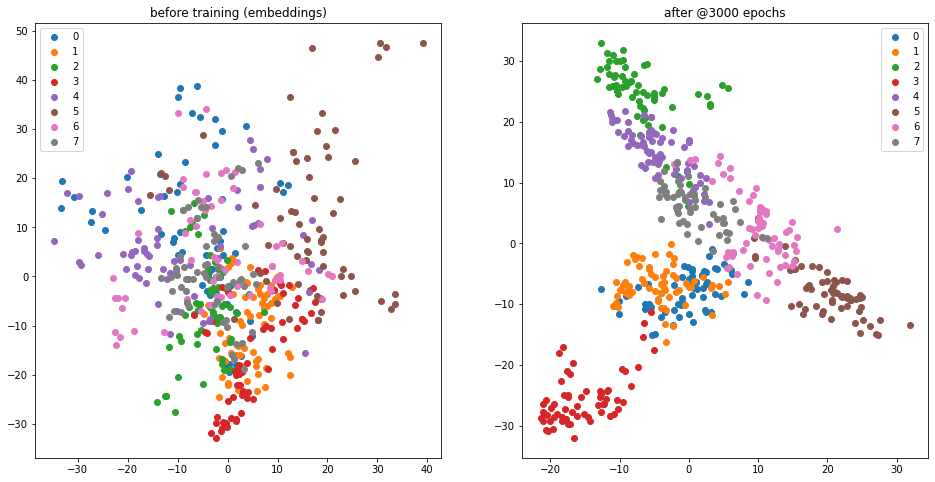

In [20]:

fig = plt.figure(figsize=(16, 8))
for label in test_class_labels:
    decomposed_embeddings_class = decomposed_embeddings[y_test == label]
    decomposed_gray_class = decomposed_gray[y_test == label]

    plt.subplot(1,2,1)
    plt.scatter(decomposed_gray_class[::step,1], decomposed_gray_class[::step,0],label=str(label))
    plt.title('before training (embeddings)')
    plt.legend()

    plt.subplot(1,2,2)
    plt.scatter(decomposed_embeddings_class[::step, 1], decomposed_embeddings_class[::step, 0], label=str(label))
    plt.title('after @%d epochs' % epochs)
    plt.legend()

plt.show()

C:\Users\farha\anaconda3\envs\yolov4-gpu\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\farha\anaconda3\envs\yolov4-gpu\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


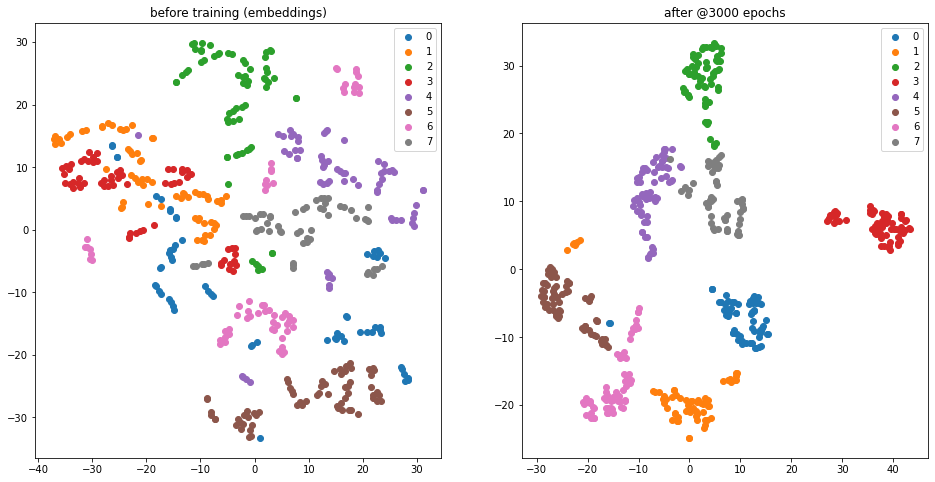

In [30]:
pca = TSNE(n_components=no_of_components)
decomposed_embeddings = pca.fit_transform(x_embeddings)
#     x_test_reshaped = np.reshape(x_test, (len(x_test), 28 * 28))
decomposed_gray = pca.fit_transform(x_embeddings_before_train)

fig = plt.figure(figsize=(16, 8))
for label in test_class_labels:
    decomposed_embeddings_class = decomposed_embeddings[y_test == label]
    decomposed_gray_class = decomposed_gray[y_test == label]

    plt.subplot(1,2,1)
    plt.scatter(decomposed_gray_class[::step,1], decomposed_gray_class[::step,0],label=str(label))
    plt.title('before training (embeddings)')
    plt.legend()

    plt.subplot(1,2,2)
    plt.scatter(decomposed_embeddings_class[::step, 1], decomposed_embeddings_class[::step, 0], label=str(label))
    plt.title('after @%d epochs' % epochs)
    plt.legend()

plt.show()

In [32]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
x_embeddings = testing_embeddings.predict(x_train)
y_embeddings = testing_embeddings.predict(x_val)

svc = SVC(C=10, gamma=0.01,probability=True)
svc.fit(x_embeddings, y_train)
valid_prediction = svc.predict(y_embeddings)
print(valid_prediction.shape)
print("validation accuracy : ", accuracy_score(y_val, valid_prediction))

(509,)
validation accuracy :  0.9449901768172888


In [54]:
x_test.shape

(509, 180, 80, 3)

In [103]:
model = load_model('best_model_triplet.hdf5',
                   custom_objects={'triplet_loss_adapted_from_tf':triplet_loss_adapted_from_tf})
embedding_size=128
input_image_shape = (180, 80, 3)
testing_embeddings = create_base_network(input_image_shape,
                                     embedding_size=embedding_size)
for layer_target, layer_source in zip(testing_embeddings.layers, model.layers[2].layers):
    weights = layer_source.get_weights()
    layer_target.set_weights(weights)
    del weights
# x_embeddings = testing_embeddings.predict(x_test)
x_embeddings = testing_embeddings.predict(np.reshape(x_test, (len(x_test), x_train.shape[1], x_train.shape[2],3)))

In [113]:
from tensorflow.keras.preprocessing import image
import tensorflow_addons as tfa
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

img_path = 'frame_42.png'
le = LabelEncoder()
labels = le.fit_transform(y_train)

img = image.load_img(img_path, target_size=(180, 80))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)

img_embeddings = testing_embeddings.predict(img_data)
preds = svc.predict_proba(img_embeddings)[0]
j = np.argmax(preds)
proba = preds[j]
name = le.classes_[j]

In [114]:
name

3

In [115]:
img_embeddings.shape

(1, 128)

In [116]:
preds

array([0.02181924, 0.04891745, 0.00520145, 0.89591834, 0.00880372,
       0.00460304, 0.00881426, 0.0059225 ])